In [2]:
import datetime as dt
import wget
import os
import pandas as pd
import numpy as np
from zipfile import ZipFile
from timeit import default_timer as timer
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField
from keras.utils import load_img
from keras.utils import save_img
from keras.utils import img_to_array
from keras.utils import array_to_img
import funcoes as f
import asyncio

%load_ext autoreload
%autoreload 2

## Constantes

In [33]:
# define o ticker do ativo que vou usar pra treinar o modelo
ticker = "BTCUSDT"
# timeframes precisa estar em ordem crescente e começar em 1s ou 1m
timeframes = ("1m", "5m", "15m", "30m", "1h", "2h", "4h", "8h", "1d")
# quantos períodos vamos olhar pro passado
lookback = 20
# numero de quantis pra usar no markov transition field. Precisa tunar.
quantis = 3
# pega número de timeframes por minuto ou segundo
timeframes_padronizado = tuple(f.timeframes_mesma_unidade(timeframes))
# tamanho das batches de treinamento. Tem mais a ver com velocidade de processamento e não interfere muito nos resultados
batch_size = 200

## Prepara os dados

#### Só rodar se precisar baixar e processar tudo de novo!

In [5]:
# baixa os dados e junta cada timeframe e junta em 1 csv por timeframe
# retorna None se arquivo processado já existe e timeframe se ele criou um arquivo do 0
lista_processados = []
for timeframe in timeframes:
    lista_processados.append(f.baixa_e_concatena(ticker= ticker, timeframe=timeframe, ano_inicial=2017))

BTCUSDT-1m já processado
BTCUSDT-5m já processado
BTCUSDT-15m já processado
BTCUSDT-30m já processado
BTCUSDT-1h já processado
BTCUSDT-2h já processado
BTCUSDT-4h já processado
BTCUSDT-8h já processado
BTCUSDT-1d já processado


In [6]:
# insere linhas sem dados e preenche com 0
# só corrige os timeframes que foram processados anteriormente
lista_p_correcao = [item for item in lista_processados if item != None]
f.corrige_arquivos(lista_p_correcao)

Nada corrigido


## Cria janelas, GAF images e salva como imagem
Imagens ficam localizadas na pasta dados e são separadas por clissificação de compra ou venda

In [4]:
# cria uma lista de numpy arrays com os dados de cada timeframe.
# Eles estão organizados na mesma ordem que os timeframes
dfs = [(pd.read_csv(f"./Dados/Processados/BTCUSDT-{timeframe}.csv", 
                      usecols=["Close time", "Close"])[::-1][["Close", "Close time"]]).to_numpy(dtype="float32") for timeframe in timeframes]
dfs = tuple(dfs)
dfs[0]

array([[1.6542400e+04, 1.6725311e+12],
       [1.6536420e+04, 1.6725311e+12],
       [1.6537779e+04, 1.6725310e+12],
       ...,
       [4.2805601e+03, 1.5029426e+12],
       [4.2614800e+03, 1.5029425e+12],
       [4.2614800e+03, 1.5029425e+12]], dtype=float32)

In [ ]:
# pra poder rodar asincrono no jupyter precisa ter isso no topo da celula
import nest_asyncio
nest_asyncio.apply()


if __name__ == '__main__':
    ultima_linha = len(dfs[0])-(lookback*timeframes_padronizado[-1])
    print(ultima_linha)
    #linhas = ultima_linha
    linhas = 10000
    
    start = timer()
    f.roda_async(linhas, dfs, lookback, quantis)
    end = timer()

    print("Tempo de execução: ",end - start)
    print("Tempo estimado para execução completa: ", (ultima_linha/linhas)*(end - start)/60, " min")

- paralelo threadpool = 149 min. 32 seg
- async = 131 min 28 seg
- normal = 167 min 35 seg
- paralelo pool = N/A
- async threadpool = 450 min 96 seg

# Modelo

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.svm import SVC

Alimentar o modelo

In [36]:
train_data = image_dataset_from_directory("./Dados/Imagens/",
                                                   label_mode="binary",
                                                  validation_split=0.2,
                                                  batch_size=batch_size,
                                                  subset="training",
                                                  seed=1337)

test_data = image_dataset_from_directory("./Dados/Imagens/",
                                                   label_mode="binary",
                                                  validation_split=0.8,
                                                  batch_size=batch_size,
                                                  subset="training",
                                                  seed=1337)
train_data, test_data

Found 2564023 files belonging to 2 classes.
Using 2051219 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

Definir modelo

In [37]:
def create_model():
    # define our MLP network
    model = keras.Sequential()
    #model.add(layers.Input(shape=(20, 180, 3)))
    #model.add(layers.Input(shape=(20, 20, 3)))
    
    
    # primeira convolucao
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding="same", input_shape = (20, 180, 3)))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    
    # segunda convolucao
    #model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"))
    #model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"))
    #model.add(layers.MaxPool2D(pool_size=(2, 2)))
    #model.add(layers.Dropout(0.25))
    
    # terceira
    #model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"))
    #model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"))
    #model.add(layers.MaxPool2D(pool_size=(2, 2)))
    
    # FC_1024
    #model.add(layers.Dense(1, activation="softmax"))
    
    return model
model = create_model()
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 20, 180, 32)       896       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 10, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 10, 90, 32)        0         
                                                                 
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compilar e treinar
#model.compile()

In [45]:
# Primeira etapa seria treinar esse modelo pra depois pegar um output da layer flatten pra svm.
# primeiro fazer sem treinar só pra ver o que a svm dá
# depois pego os dados de x e y do gerador e passo pro svm
model.add(layers.Flatten())
saida = model.layers[3].output
# dar predict no modelo com a ultima layer sendo o flatten e usando x_train


# prototipo. nao entendi o argmax aqui. acho que só serve se é categorical. testar remover e deixar so o predict
# nao rodar em tudo de uma vez tbm, pq tem muito dado
predictions = np.array([])
labels =  np.array([])
for x, y in train_data:
    predictions = np.concatenate([predictions, **np.argmax**(model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])


modelo_svm = SVC()
model_svm.fit(predictions, labels)



<KerasTensor: shape=(None, 28800) dtype=float32 (created by layer 'flatten')>

In [ ]:
train_label = np.concatenate([y for x, y in train_data], axis=0)

In [41]:
model.layers[2].output

<KerasTensor: shape=(None, 10, 90, 32) dtype=float32 (created by layer 'dropout_32')>

In [ ]:
'''
Explicação de como fazer:

You just select the output of a layer of the neural network and use that as a feature vector to train a SVM. Generally one normalizes the feature vectors as well.

About implementation, you just have to train a neural network, then select one of the layers (usually the ones right before the fully connected layers or the first fully connected one), run the neural network on your dataset, store all the feature vectors, then train an SVM with a different library (e.g sklearn).

'''

# Problemas:
- Se for usar GAF image vai ter uma imagem 20x20 por coluna (supondo que estamos olhando 20 períodos no passado por vez)
- Não está claro se 1D CNN é uma boa alternativa para timeseries.

# Soluções:
#### 1
- Usar GAF de qualquer maneira para tentar replicar os resultados do trabalho do BARRA, usando apenas os preços de fechamento e ver se os resultados melhoram com CSVM
- Depois se eu quiser adiciono mais dados, mas a imagem vai ficar bem grande. (5 colunas de t-20 resulta em uma imagem de 100x100). GAF usando mais dados seria o melhor dos mundos.

#### 2
- Usar 1D CNN com todos os dados disponíveis
- Metodo completamente diferente do do BARRA. Não usa GAF images. Provavelmente mais fácil

### A partir daqui são só testes

In [62]:
# exemplo de input que vai ser transformado em GAF dimesão é timeframes(linhas) x lookback(colunas) 
pd.DataFrame(cria_janela(100, dfs, lookback)[0], columns = timeframes)

,1m,5m,15m,30m,1h,2h,4h,8h,1d
0,16531.619141,16531.619141,16565.380859,16548.279297,16548.279297,16548.279297,16570.140625,16590.099609,16607.480469
1,16519.140625,16565.380859,16548.279297,16563.839844,16568.599609,16570.140625,16590.099609,16565.089844,16633.470703
2,16547.339844,16556.179688,16560.529297,16568.599609,16570.140625,16582.080078,16567.150391,16607.480469,16547.310547
3,16554.119141,16543.939453,16563.839844,16570.710938,16577.789062,16590.099609,16565.089844,16555.259766,16706.359375
4,16562.730469,16548.279297,16566.310547,16570.140625,16582.080078,16600.890625,16552.460938,16474.929688,16919.390625
5,16565.380859,16549.589844,16568.599609,16572.169922,16600.390625,16567.150391,16607.480469,16633.470703,16832.109375
6,16562.259766,16556.150391,16570.460938,16577.789062,16590.099609,16544.259766,16525.369141,16616.599609,16836.119141
7,16561.810547,16560.529297,16570.710938,16577.130859,16586.429688,16565.089844,16555.259766,16556.369141,16778.500000
8,16565.109375,16560.070312,16569.759766,16582.080078,16600.890625,16538.759766,16496.269531,16547.310547,16821.429688
9,16562.490234,16557.919922,16570.140625,16583.429688,16575.439453,16552.460938,16474.929688,16578.519531,16824.669922


In [ ]:
# gera pra todos os tempos
# define se é long ou short
# transforma em gaf
# salva como imagem nas pastas long e short
# passa pro keras imagedatagenerator

## OLD

In [6]:
# pra poder rodar asincrono precisa ter isso no topo da celula
import nest_asyncio
nest_asyncio.apply()


if __name__ == '__main__':
    ultima_linha = len(dfs[0])-(lookback*timeframes_padronizado[-1])
    print(ultima_linha)
    linhas = ultima_linha
    linhas = 10000
    
    start = timer()
    f.roda_async(linhas, dfs, lookback, quantis)
    #f.roda_paralelo(linhas, dfs, lookback, quantis)
    #for linha in range(linhas):
    #    df_janela, decisao = f.cria_janela(linha, dfs, lookback)
    #    # se decisao não é long nem short ou tem um buraco nos dados no meio da janela, pula a iteração
    #    if decisao == None or (0 in df_janela):
    #        continue
    #    # cria gaf image
    #    img_array = f.cria_gaf(df_janela.T, quantis)
    #    # salva como imagem na pasta long ou short
    #    save_img(f'./Dados/Imagens/{decisao}/{linha}.png', array_to_img(img_array), scale=False)
    end = timer()

    print("Tempo de execução: ",end - start)
    print("Tempo estimado para execução completa: ", (ultima_linha/linhas)*(end - start)/60, " min")

2797680
Tempo de execução:  96.5389822
Tempo estimado para execução completa:  450.14196620216  min


In [22]:
#%%timeit
# Paralelizar.

linha = 0

linhas = 10000
start = timer()
# ultima linha é a qtd de linhas de 1 min - (lookback (20 dias) x qtd de minutos em um dia) 
ultima_linha = len(dfs[0])-(lookback*timeframes_padronizado[-1])
print(ultima_linha)
for linha in range(linhas):# range(ultima_linha+1):
    df_janela, decisao = cria_janela(linha, dfs, lookback)
    # se decisao não é long nem short ou tem um buraco nos dados no meio da janela, pula a iteração
    if decisao == None or (0 in df_janela):
        continue
    # cria gaf image
    img_array = cria_gaf(df_janela.T, quantis)
    # salva como imagem na pasta long ou short
    save_img(f'./Dados/Imagens/{decisao}/{linha}.png', array_to_img(img_array), scale=False)
end = timer()
print("Tempo de execução: ",end - start)
print("Tempo estimado para execução completa: ", (ultima_linha/linhas)*(end - start)/60, " min")
#pd.DataFrame(df_janela)

2797680
Tempo de execução:  15.488407899999856
Tempo estimado para execução completa:  72.21934835611933  min


In [85]:
if __name__ == '__main__':
    # medicao de tempo por funcao

    linha = 0

    linhas = 100
    start = timer()
    # ultima linha é a qtd de linhas de 1 min - (lookback (20 dias) x qtd de minutos em um dia) 
    ultima_linha = len(dfs[0])-(lookback*timeframes_padronizado[-1])
    print(ultima_linha)
    for linha in range(linhas):# range(ultima_linha+1):
        cria_janela_ini = timer()
        df_janela, decisao = cria_janela(linha, dfs, lookback)
        cria_janela_fim = timer()
        # se não é long nem short ou tem um buraco nos dados no meio da janela, pula a iteração
        if decisao == None or (0 in df_janela):
            continue
        # cria gaf image
        cria_gaf_ini = timer()
        img_array = cria_gaf(df_janela.T, quantis)
        cria_gaf_fim = timer()
        # salva como imagem na pasta long ou short
        save_img_ini = timer()
        save_img(f'./Dados/Imagens/{decisao}/{linha}.png', array_to_img(img_array), scale=False)
        save_img_fim = timer()
    end = timer()
    print("Tempo de execução: ",end - start)
    print("Tempo estimado para execução completa: ", (ultima_linha/linhas)*(end - start)/60, " min")

    cria_janela_t = cria_janela_fim - cria_janela_ini
    cria_gaf_t = cria_gaf_fim - cria_gaf_ini
    save_img_t = save_img_fim - save_img_ini


    print("Tempo cria_janela: ", cria_janela_t*linhas)
    print("Tempo cria_gaf: ", cria_gaf_t*linhas)
    print("Tempo save_img: ", save_img_t*linhas)
    print((cria_janela_t + cria_gaf_t + save_img_t)*linhas)
    #pd.DataFrame(df_janela)

2797680
Tempo de execução:  0.15151669999977457
Tempo estimado para execução completa:  70.64920687589488  min
Tempo cria_janela:  0.01038999998854706
Tempo cria_gaf:  0.06572000002051936
Tempo save_img:  0.06828999994468177
0.001443999999537482


In [7]:
if __name__ == '__main__':
    # prova que as imagens salvas são iguais aos dados originais. 
    # Primeiro plota o dado puro e depois salvando e lendo como imagem
    import plotly.express as px

    df_janela, long = f.cria_janela(99,dfs, lookback)
    print(long)
    img_array = f.cria_gaf(df_janela.T, quantis)
    fig = px.imshow(img_array, zmin=-1., zmax=1.)
    print(img_array.shape)
    fig.show()


    # example of saving an image with the Keras API
    from keras.utils import load_img
    from keras.utils import save_img
    from keras.utils import img_to_array
    from keras.utils import array_to_img


    save_img('teste.png', array_to_img(img_array), scale=False)
    # load the image to confirm it was saved correctly
    img = load_img('teste.png')
    img = img_to_array(img)

    fig = px.imshow(img)#, zmin=-1., zmax=1.)
    fig.show()

short
(20, 180, 3)


9 imagens de dimensão (20, 20) com 3 canais (RGB)


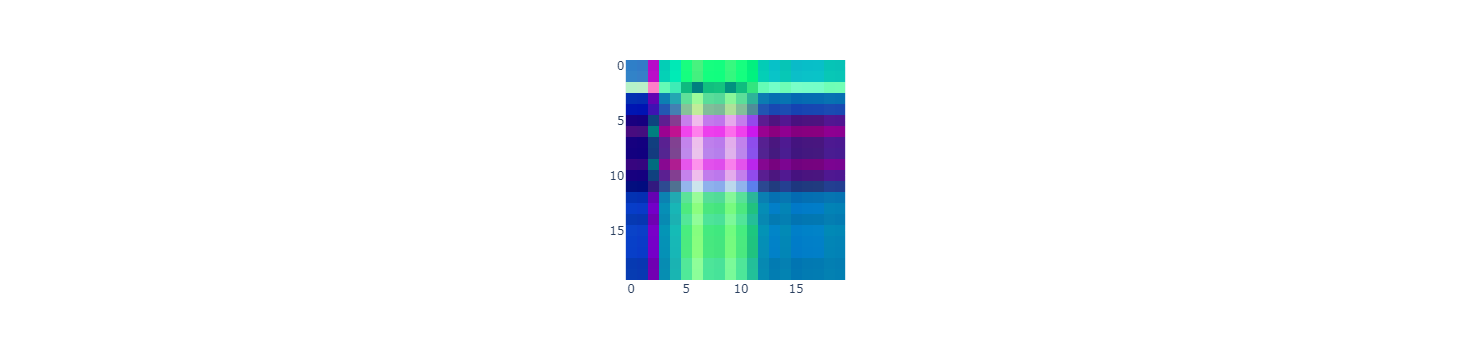

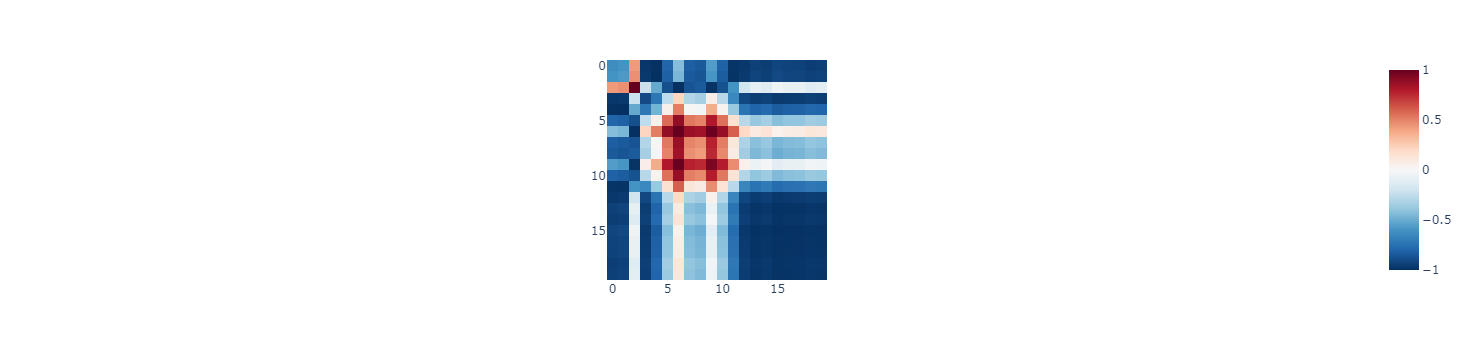

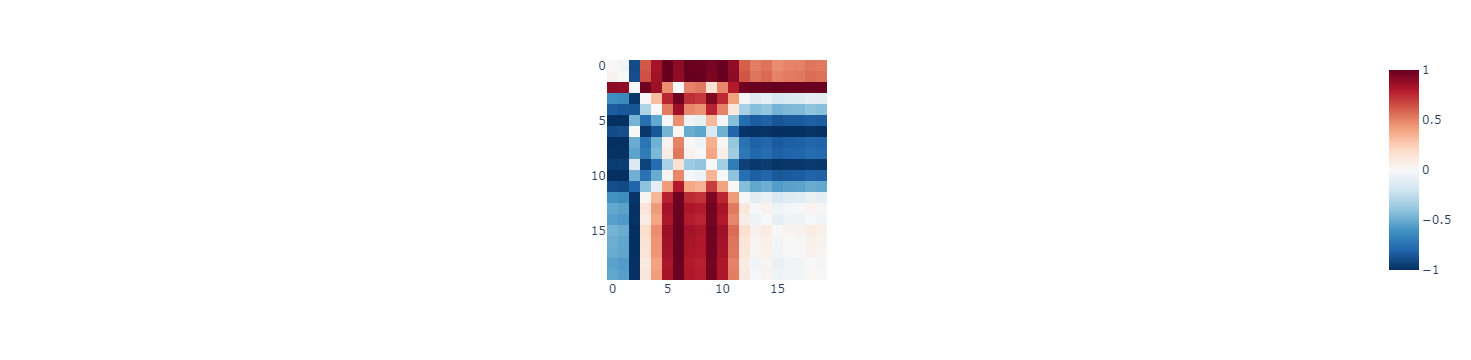

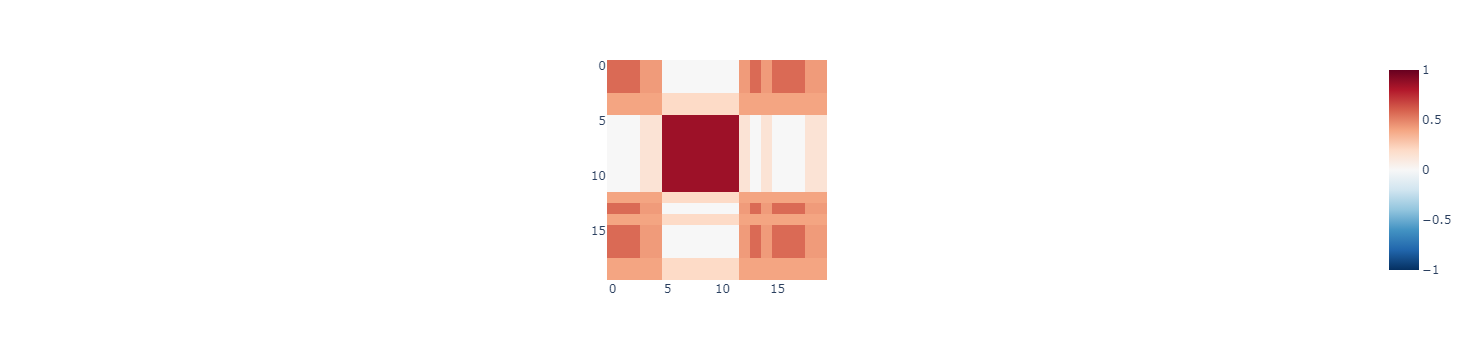

In [108]:
if __name__ == '__main__':
    # demonstração do que é cada canal de uma imagem

    def create_gaf2(dft, quantis):
        # cria uma imagem gaf RGB
        # precisa da df_janela transposta pra funcionar
        gasf = GramianAngularField(method='summation')#, image_size=0.5)
        gadf = GramianAngularField(method='difference')#, image_size=0.5)
        mtf = MarkovTransitionField(n_bins=quantis)#, image_size=0.5)# , 
        gadf = gadf.transform(dft)
        gasf = gasf.transform(dft)
        mtf = mtf.transform(dft)

        # une os 3 metodos em uma unica imagem com 3 canais (RGB) com np.stack
        # depois une as 9(timeframes) matrizes geradas  horizontalmente com np.vstack
        return (np.stack((gasf,gadf, mtf), axis=-1))

    df_janela = cria_janela(99,dfs, lookback)[0]
    img = create_gaf2(df_janela.T, quantis)
    print(img.shape[0], "imagens de dimensão", img.shape[1:3], "com", img.shape[3], "canais (RGB)")

    # representação visual do que cada timeframe vira
    fig = px.imshow(img[0, :, :, :], zmin=-1., zmax=1.)# color_continuous_scale='RdBu_r'
    fig.show()

    fig = px.imshow(img[0, :, :, 0], zmin=-1., zmax=1., color_continuous_scale='RdBu_r')
    fig.show()

    fig = px.imshow(img[0, :, :, 1], zmin=-1., zmax=1., color_continuous_scale='RdBu_r')
    fig.show()

    fig = px.imshow(img[0, :, :, 2], zmin=-1., zmax=1., color_continuous_scale='RdBu_r')
    fig.show()

In [38]:
if __name__ == '__main__':
    # cria um df com close times e close prices pra verificar as janelas
    dfs = [(pd.read_csv(f"./Dados/Processados/BTCUSDT-{timeframe}.csv", 
                          usecols=["Close time", "Close"])[["Close", "Close time"]][::-1]).rename(columns={"Close" : f"Close_{timeframe}",
                                                                                                          "Close time" : f"Close time_{timeframe}"}).reset_index(drop=True) for timeframe in timeframes]

    dfs_teste = pd.concat(dfs, axis=1)
    for timeframe in timeframes:
        dfs_teste[f"Close time_{timeframe}"] = pd.to_datetime(dfs_teste[f"Close time_{timeframe}"], unit="ms")
    dfs_teste[:2000].to_csv("teste.csv")

In [51]:
if __name__ == '__main__':
    # cria um dicionário de dataframes. Pra acessar é só falar o timeframe desejado
    dfs = {}
    for timeframe in timeframes:
        dfs[timeframe] = (pd.read_csv(f"./Dados/Processados/BTCUSDT-{timeframe}.csv", 
                          usecols=["Close time", "Close"])[::-1])
    dfs["1m"]

,Close,Close time
2817998,16542.40,1672531199999
2817997,16536.42,1672531139999
2817996,16537.78,1672531079999
2817995,16540.52,1672531019999
2817994,16539.28,1672530959999
...,...,...
4,4261.48,1502942699999
3,4261.48,1502942639999
2,4280.56,1502942579999
1,4261.48,1502942519999


In [52]:
if __name__ == '__main__':
    %%time

    # versao com query melhorada
    # confirmei que funciona batendo o resultado com o da versao antiga e lenta
    # ver se dá pra usar só numpy (fica mto escroto)
    # e depois paralelismo

    lookback = 20
    linha = 0

    colunas = [f"Close_{timeframe}" for timeframe in timeframes]
    colunas.append("Close time")

    # pra todas as linhas
    print("Num linhas: ", len(dfs[timeframes[0]])-lookback)
    #for linha in range(100):
    for linha in [100]:
    #for linha in range(len(df)-lookback):
        # cria o esqueleto da janela com o primeiro timeframe
        df_janela = pd.DataFrame(np.nan, index=range(0,lookback), columns= colunas)
        df_janela[[colunas[0], colunas[-1]]] = dfs[timeframes[0]].iloc[linha:linha+lookback].reset_index(drop=True)
        # junta o preço de fechamento pra todos os timeframes
        i = 1
        for timeframe in timeframes[1:]:
            # pega o numero da linha o primeiro closetime do timeframe é igual ou menor que o da janela atual
            index = (dfs[timeframe].iloc[:,1] <= df_janela.iat[0,-1]).values.argmax()
            # coloca as 20 (lookback) linhas subsequentes dentro da janela
            df_janela.iloc[:, i] = dfs[timeframe].iloc[index:index+lookback, 0].reset_index(drop=True)
            i += 1
        # remove a coluna close time, que foi utilizada pra sincronizar cada timeframe
        df_janela.drop("Close time", inplace=True, axis=1)
        # define se é long ou short
        # create_gaf(df_janela)
        # salva na pasta long ou short


    df_janela2 = df_janela

Num linhas:  2817979
Wall time: 3.98 ms


In [61]:
if __name__ == '__main__':
    # criação de DF gigante e cheio de nan's

    def une_timeframes(timeframes=timeframes):
        # junta todos os timeframes em um df só

        # pega o primeiro timeframe com as colunas desejadas
        df = pd.read_csv(f"./Dados/Processados/BTCUSDT-{timeframes[0]}.csv", index_col = "Close time"
                         , usecols=["Close time","Open", "High", "Low", "Close", "Volume", "Number of trades"])
        #df.index = pd.to_datetime(df.index, unit="ms")

        # coloca o sufixo nas colunas do menor timeframe
        df.columns = df.columns+f"_{timeframes[0]}"
        print(timeframes[0])

        # junta todos os outros timeframes e coloca o sufixo correto
        for timeframe in timeframes[1:]:
            print(timeframe)
            df2 = pd.read_csv(f"./Dados/Processados/BTCUSDT-{timeframe}.csv", index_col = "Close time",
                             usecols=["Close time","Open", "High", "Low", "Close", "Volume", "Number of trades"])
            df2.columns = df2.columns+f"_{timeframe}"
            df = df.merge(df2, how="left", on=["Close time"])#, suffixes=(None, f"_{timeframe}"))


        # transforma o index em datetime
        df.index = pd.to_datetime(df.index, unit="ms")

        #inverte a ordem do df pq vamos usar ele do fim pro começo pra fazer as janelas
        df.sort_index(axis=0, inplace = True, ascending=False)
        return(df)
    df = une_timeframes(timeframes)
    df[99:].head(20)

1m
5m
15m
30m
1h
2h
4h
8h
1d


,Open_1m,High_1m,Low_1m,Close_1m,Volume_1m,Number of trades_1m,Open_5m,High_5m,Low_5m,Close_5m,...,Low_8h,Close_8h,Volume_8h,Number of trades_8h,Open_1d,High_1d,Low_1d,Close_1d,Volume_1d,Number of trades_1d
Close time,,,,,,,,,,,,,,,,,,,,,
2022-12-31 22:20:59.999,16531.61,16537.39,16528.91,16532.26,110.79296,2708,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:19:59.999,16519.14,16531.70,16506.36,16531.62,638.64815,8301,16564.95,16565.62,16506.36,16531.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:18:59.999,16547.34,16547.85,16515.16,16519.14,408.04045,6108,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:17:59.999,16554.12,16554.23,16545.78,16547.34,96.98766,2665,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:16:59.999,16562.27,16563.55,16553.57,16554.12,109.60176,2619,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:15:59.999,16564.95,16565.62,16561.78,16562.73,76.53378,1809,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:14:59.999,16562.26,16567.49,16562.14,16565.38,98.09439,2583,16556.18,16567.49,16555.75,16565.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:13:59.999,16562.15,16563.80,16560.68,16562.26,70.03443,1721,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:12:59.999,16565.11,16565.16,16560.26,16561.81,77.08899,1988,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
if __name__ == '__main__':
    %%time
    # solução de janela usando uma df gigante. Bem mais lento
    # cria janela de precos
    lookback = 20
    linha = 0
    # tentar fazer um loop pra pegar tudo

    # pra todas as linhas
    print("Num linhas: ", len(df)-lookback)
    for linha in [2000000]:
    #for linha in range(len(df)-lookback):
        # zera df_janela
        df_janela = pd.DataFrame()
        for timeframe in timeframes:
            # insere na ultima coluna; com o nome de Close_timeframe ;
            # df a partir da linha atual até linha atual + lookback
            #df_janela[f"Close_{timeframe}"] = df[f"Close_{timeframe}"].iloc[linha:].dropna().iloc[:lookback].reset_index(drop=True)
            df_janela.insert(len(df_janela.columns),(f"Close_{timeframe}"),df[f"Close_{timeframe}"].iloc[linha:].dropna().iloc[:lookback].to_list())
        #print(linha)
        # define se é long ou short
        # create_gaf(df_janela)
        # salva na pasta long ou short
    df_janela
    df_janela2 = df_janela
    # funciona, mas está muito lento
    # se tirar o dropna vai de 4,4 seg pra 190 ms
    # não unir mais tudo

Num linhas:  2817979
Wall time: 12.7 ms


In [112]:
if __name__ == '__main__':
    pd.DataFrame(cria_janela(99)[0])

,0,1,2,3,4,5,6,7,8
0,16532.259766,16531.619141,16565.380859,16548.279297,16548.279297,16548.279297,16570.140625,16590.099609,16607.480469
1,16531.619141,16565.380859,16548.279297,16563.839844,16568.599609,16570.140625,16590.099609,16565.089844,16633.470703
2,16519.140625,16556.179688,16560.529297,16568.599609,16570.140625,16582.080078,16567.150391,16607.480469,16547.310547
3,16547.339844,16543.939453,16563.839844,16570.710938,16577.789062,16590.099609,16565.089844,16555.259766,16706.359375
4,16554.119141,16548.279297,16566.310547,16570.140625,16582.080078,16600.890625,16552.460938,16474.929688,16919.390625
5,16562.730469,16549.589844,16568.599609,16572.169922,16600.390625,16567.150391,16607.480469,16633.470703,16832.109375
6,16565.380859,16556.150391,16570.460938,16577.789062,16590.099609,16544.259766,16525.369141,16616.599609,16836.119141
7,16562.259766,16560.529297,16570.710938,16577.130859,16586.429688,16565.089844,16555.259766,16556.369141,16778.500000
8,16561.810547,16560.070312,16569.759766,16582.080078,16600.890625,16538.759766,16496.269531,16547.310547,16821.429688
9,16565.109375,16557.919922,16570.140625,16583.429688,16575.439453,16552.460938,16474.929688,16578.519531,16824.669922


In [111]:
if __name__ == '__main__':
    df = pd.read_csv(f"./Dados/Processados/BTCUSDT-1m.csv", index_col = "Close time"
                         , usecols=["Close time","Open", "High", "Low", "Close", "Volume", "Number of trades"])
    df.index = pd.to_datetime(df.index, unit="ms")
    df

,Open,High,Low,Close,Volume,Number of trades
Close time,,,,,,
2017-08-17 04:00:59.999,4261.48,4261.48,4261.48,4261.48,1.775183,3
2017-08-17 04:01:59.999,4261.48,4261.48,4261.48,4261.48,0.000000,0
2017-08-17 04:02:59.999,4280.56,4280.56,4280.56,4280.56,0.261074,2
2017-08-17 04:03:59.999,4261.48,4261.48,4261.48,4261.48,0.012008,3
2017-08-17 04:04:59.999,4261.48,4261.48,4261.48,4261.48,0.140796,1
...,...,...,...,...,...,...
2022-11-30 23:55:59.999,17175.50,17215.59,17170.01,17173.33,531.365170,6445
2022-11-30 23:56:59.999,17173.33,17175.40,17150.70,17167.16,322.428780,7797
2022-11-30 23:57:59.999,17165.50,17170.80,17156.77,17161.26,160.506230,4056


# Falhas
Numba. Mais devagar mesmo 100% nopython. Talvez devido a falta de suporte ao argmax(), que fez com que eu tivesse que criar uma função pra encontrar o primeiro menor. No futuro, tentar pegar o indexador somando linhas.

In [7]:
if __name__ == '__main__':
    # aparentemente o numba precisa de uma lista especializada quando é lista de listas
    from numba.typed import List
    import numba_funcs

    dfs = numba_funcs.dfs_numba(timeframes)

In [8]:
if __name__ == '__main__':
    lookback = 20

    pd.DataFrame(numba_funcs.cria_janela(99, dfs, lookback))

,0,1,2,3,4,5,6,7,8
0,16532.259766,16531.619141,16565.380859,16548.279297,16548.279297,16548.279297,16570.140625,16590.099609,16607.480469
1,16531.619141,16565.380859,16548.279297,16563.839844,16568.599609,16570.140625,16590.099609,16565.089844,16633.470703
2,16519.140625,16556.179688,16560.529297,16568.599609,16570.140625,16582.080078,16567.150391,16607.480469,16547.310547
3,16547.339844,16543.939453,16563.839844,16570.710938,16577.789062,16590.099609,16565.089844,16555.259766,16706.359375
4,16554.119141,16548.279297,16566.310547,16570.140625,16582.080078,16600.890625,16552.460938,16474.929688,16919.390625
5,16562.730469,16549.589844,16568.599609,16572.169922,16600.390625,16567.150391,16607.480469,16633.470703,16832.109375
6,16565.380859,16556.150391,16570.460938,16577.789062,16590.099609,16544.259766,16525.369141,16616.599609,16836.119141
7,16562.259766,16560.529297,16570.710938,16577.130859,16586.429688,16565.089844,16555.259766,16556.369141,16778.500000
8,16561.810547,16560.070312,16569.759766,16582.080078,16600.890625,16538.759766,16496.269531,16547.310547,16821.429688
9,16565.109375,16557.919922,16570.140625,16583.429688,16575.439453,16552.460938,16474.929688,16578.519531,16824.669922


In [115]:
if __name__ == '__main__':
    #ultima_linha = ((len(dfs[-1])-lookback-6)*timeframes_padronizado[-1])
    # ultima linha é a qtd de linhas de 1 min - (lookback (20 dias) x qtd de minutos em um dia) 
    ultima_linha = len(dfs[0])-(lookback*timeframes_padronizado[-1])
    print(ultima_linha)
    cria_janela(ultima_linha+200, dfs, lookback)

2797680


(array([[4395.  , 4395.  , 4415.07, 4415.07, 4366.47, 4366.47, 4366.47,
         4366.47, 4366.47],
        [4388.45, 4382.4 , 4368.01, 4366.47, 4423.46, 4374.43, 4442.48,
         4151.  , 4100.11],
        [4384.  , 4415.07, 4366.47, 4450.52, 4374.43, 4442.48, 4151.  ,
         4190.4 , 4509.08],
        [4383.85, 4403.  , 4426.27, 4423.46, 4431.61, 4322.47, 4246.82,
         4100.11, 4472.14],
        [4382.4 , 4367.99, 4450.52, 4413.99, 4442.48, 4151.  , 4190.4 ,
         4015.03, 4834.91],
        [4382.4 , 4368.01, 4425.  , 4374.43, 4390.14, 4261.04, 3988.04,
         4186.96, 4724.89],
        [4365.74, 4368.  , 4423.46, 4399.42, 4322.47, 4246.82, 4100.11,
         4509.08, 4555.14],
        [4365.74, 4368.05, 4415.72, 4431.61, 4142.69, 4120.05, 4203.67,
         4384.15, 4587.48],
        [4365.74, 4366.47, 4413.99, 4381.21, 4151.  , 4190.4 , 4015.03,
         4620.87, 4386.69],
        [4397.02, 4370.85, 4397.99, 4442.48, 4229.  , 3960.01, 4153.  ,
         4472.14, 4310.01],
